 # Введение в `Feature Engineering`

# Как придумывать признаки для генерации? 
    
<div class="alert alert-info">
    
- 🏁 Начать с сырых данных. 
    
- 🧩 Брать все, что есть. Покрыть признаками всю имеющуюся информацию в данных
- 🧠 Предполагать, от чего зависит таргет? (время износа от числа поездок) 
- 🤔 Смотреть визуально на классы/ошибки и делать предположения. Какие полезны?
- ⚠️ Совсем много признаков может быть вредно. Потом придется отфильтровывать. 

#  Анализируем данные по машинам и таргетам    

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
847,D22902572P,Kia Rio X,economy,petrol,3.94,2013,53235,2017,41.51,engine_check
1067,B22876755u,Smart ForFour,economy,petrol,4.34,2016,94561,2020,29.12,gear_stick
778,o-1891967P,Kia Sportage,standart,petrol,4.68,2014,68376,2017,43.69,engine_overheat


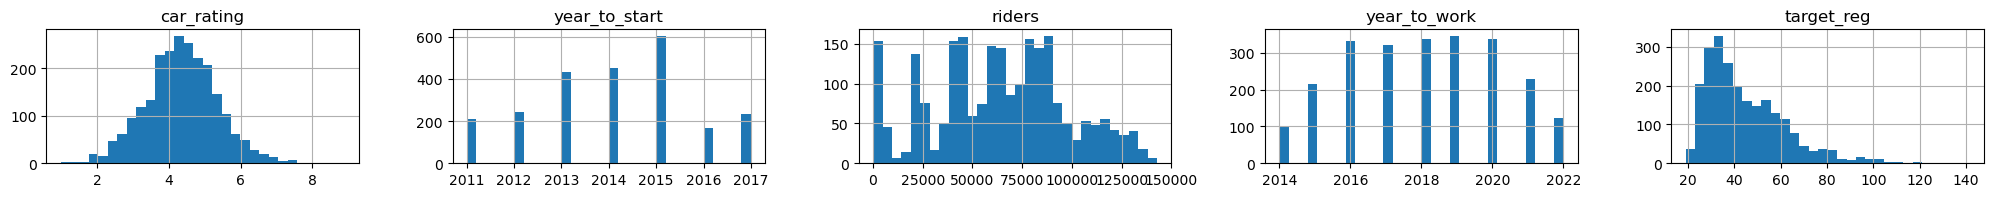

In [2]:
import numpy as np
import pandas as pd

train = pd.read_csv("car_train.csv")
print(train.shape)
train.hist(figsize=(25, 4), layout=(2, 5), bins=30)
train.sample(3)

<div class="alert alert-info">

* `car_id` - идентификатор машины
* `model` / `car_type` / `fuel_type` - марка, класс и тип топлива машины
* `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
* `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке 
* `target_reg` - количество дней до поломки.
* `target_class` - класс поломки (всего 9 видов)

# Информация про поездки

(739500, 14)


,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
330745,V94969993d,X14239142s,R1I,2020-03-17,4.46,41,568,63,98.000000,1,1.969178e+03,0,-24.068145,-7.987
276063,v53974313l,T-2093464U,F1n,2020-02-22,6.00,28407,340877,37,90.208126,0,1.091004e+06,0,7.781487,49.383
280286,G21881197F,T10888967t,g1T,2020-03-18,4.05,57,1136,53,67.497954,3,2.745684e+03,0,-10.008430,-3.721


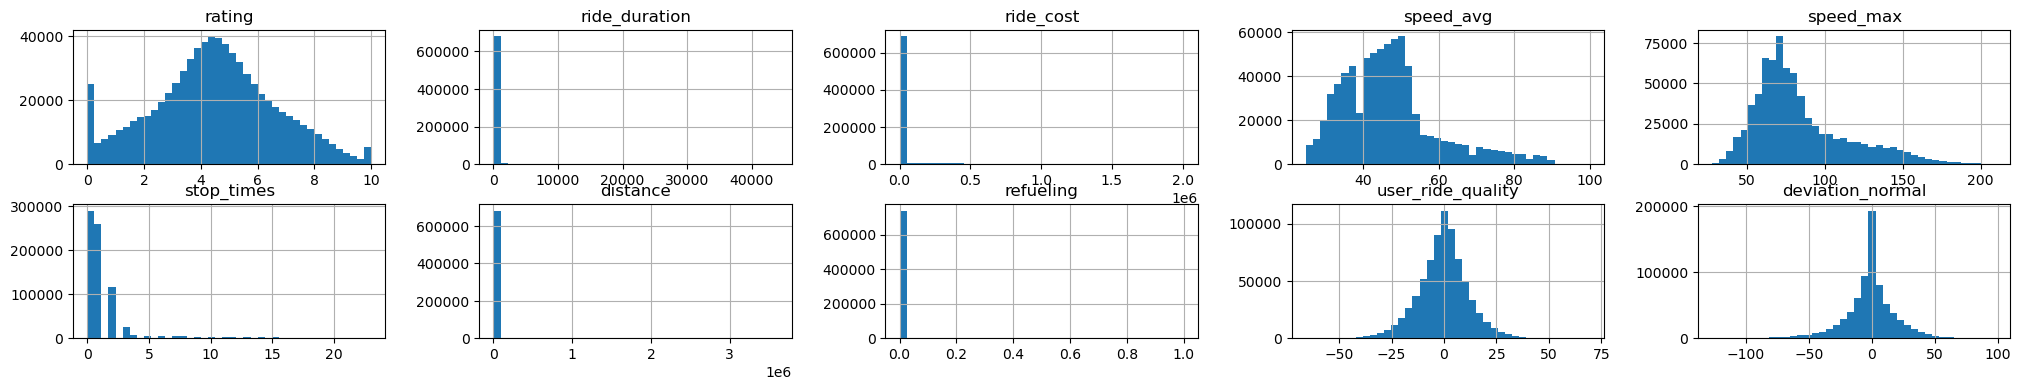

In [4]:
rides_info = pd.read_csv("rides_info.csv")
print(rides_info.shape)
rides_info.hist(figsize=(25, 4), layout=(2, 5), bins=40)
rides_info.sample(3)

<div class="alert alert-info">

* `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
* `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
* `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
* `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
* `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
* `user_ride_quality` - оценка манеры вождения в машины водителя, определенная скоринговой ML системой сервиса.
* `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы).

#  Данные про ремонт машин (fix_info)

(146000, 6)


,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
73263,a-1190397Y,HJ,2019-2-27 22:27,repair,7.2,36
124984,b34607341j,PS,2020-3-1 12:49,repair,4.5,3
144893,A-1463575c,KB,2020-1-2 8:13,reparking,1.0,28


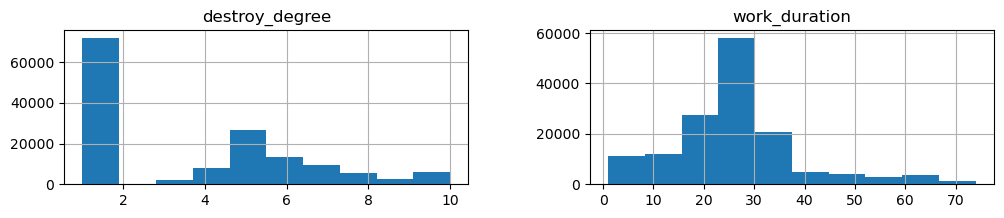

In [5]:
fix_info = pd.read_csv("fix_info.csv").sort_values('worker_id')
print(fix_info.shape)
fix_info.hist(figsize=(12, 2))
fix_info.sample(3)

* `worker_id` / `car_id` - идентификатор работника и машины соответственно 
* `work_type` / `work_duration` - тип и длительность (в часах) проводимой работы
* `destroy_degree` - степень износа/поврежденности машины в случае поломки
* `fix_date` - время начала ремонта (время снятия машины с линии)

# Связка: `groupby()` + `agg()`

<div class="alert alert-info">

**[`df.aggregate()` == `df.agg()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.aggregate.html)** - Агрегирует с помощью одной или нескольких указанных операций/функций по заданной оси. 

__способ #1__ (не лучший)

In [6]:
fix_info.groupby("car_id", as_index=False).aggregate({
        "worker_id": ["count"],
        "work_duration": ["max", "mean"],
    }
).head(3)

car_id worker_id work_duration           
                  count           max       mean
0  A-1049127W        35            56  27.485714
1  A-1079539w        34            64  27.382353
2  A-1162143G        34            69  27.823529

<!-- # hide -->

__способ #2__ (красивый)

In [7]:
fix_info.groupby("car_id", as_index=False).agg(
    worker_id_count=("worker_id", "count"),
    work_duration_max=("work_duration", "max"),
    work_duration_mean=("work_duration", "mean"),
).head(3)

,car_id,worker_id_count,work_duration_max,work_duration_mean
0,A-1049127W,35,56,27.485714
1,A-1079539w,34,64,27.382353
2,A-1162143G,34,69,27.823529


# Связка: `groupby()` + `transform()` сохраняет исходный размер

<div class="alert alert-info">
    
**[`df.transform()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html)** - Вызывает функцию для самостоятельного создания `DataFrame` с той же формой оси, как у исходной таблицы.

__способ #1__ (хороший)

In [8]:
# Среднее время выполнения работы мастером

print(fix_info.shape)

fix_info["worker_speed"] = fix_info.groupby("worker_id")["work_duration"].transform("mean")

print(fix_info.shape)

fix_info.head(3)

(146000, 6)
(146000, 7)


,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,worker_speed
38176,m-8902512v,AB,2019-2-16 19:28,repair,5.0,59,26.219917
25968,h-5894617f,AB,2020-8-13 18:19,reparking,1.0,30,26.219917
17050,m-8965256V,AB,2020-5-1 10:20,repair,5.0,33,26.219917


__способ #2__ (плохой)

In [9]:
tmp = fix_info.groupby("worker_id", as_index=False).agg(
    work_duration_mean=("work_duration", "mean")
)

fix_info.merge(tmp, on="worker_id", how="left").head(3)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,worker_speed,work_duration_mean
0,m-8902512v,AB,2019-2-16 19:28,repair,5.0,59,26.219917,26.219917
1,h-5894617f,AB,2020-8-13 18:19,reparking,1.0,30,26.219917,26.219917
2,m-8965256V,AB,2020-5-1 10:20,repair,5.0,33,26.219917,26.219917


In [10]:
fix_info["worker_experience"] = fix_info.groupby("worker_id")["car_id"].transform(
    "count"
)
fix_info.head(3)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,worker_speed,worker_experience
38176,m-8902512v,AB,2019-2-16 19:28,repair,5.0,59,26.219917,241
25968,h-5894617f,AB,2020-8-13 18:19,reparking,1.0,30,26.219917,241
17050,m-8965256V,AB,2020-5-1 10:20,repair,5.0,33,26.219917,241


<!-- hide -->

# Связка `groupby` + `agg()`

In [11]:
fix_info.head(3)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,worker_speed,worker_experience
38176,m-8902512v,AB,2019-2-16 19:28,repair,5.0,59,26.219917,241
25968,h-5894617f,AB,2020-8-13 18:19,reparking,1.0,30,26.219917,241
17050,m-8965256V,AB,2020-5-1 10:20,repair,5.0,33,26.219917,241


In [12]:
# число уникальных значений
f_nuniq = lambda x: x.nunique()

# число значений, которые больше чем n
more_than_n_func = lambda x, n=8: sum(x > n)

# 30% перцентиль / квантиль уровня 0.3
def quant_func(x):
    return x.quantile(0.3)

In [13]:
# Функции поиска первой и второй моды для категориальных значений
first_mode = lambda x: x.value_counts().index[0]
second_mode = lambda x: x.value_counts().index[1]

In [14]:
fix_info_gr = fix_info.groupby("car_id", as_index=False).agg(
    
    # Все встроенные статистики
    worker_count=("worker_id", "count"),
    work_duration_mean=("work_duration", "mean"),
    work_duration_max=("work_duration", "max"),
    destroy_degree_std=("destroy_degree", "std"),
    destroy_degree_sum=("destroy_degree", "sum"),
    
    # Самописные функции для категорий
    work_type_nuniq=("work_type", f_nuniq),
    work_type_mode=("work_type", first_mode),
    work_type_second_mode=("work_type", second_mode),
    
    # Самописные функции для численных
    destroy_degree_crit_q=("destroy_degree", more_than_n_func),
    worker_quant_exp=("worker_experience", quant_func),
)

fix_info_gr.sample(3)

,car_id,worker_count,work_duration_mean,work_duration_max,destroy_degree_std,destroy_degree_sum,work_type_nuniq,work_type_mode,work_type_second_mode,destroy_degree_crit_q,worker_quant_exp
2951,k-2063559v,34,25.000000,51,1.965477,103.4,3,repair,reparking,0,261.9
1374,Q21021305o,34,27.000000,64,1.962646,92.2,4,repair,reparking,0,265.0
3368,p14707024B,34,27.294118,50,1.997612,96.9,4,reparking,repair,0,260.9


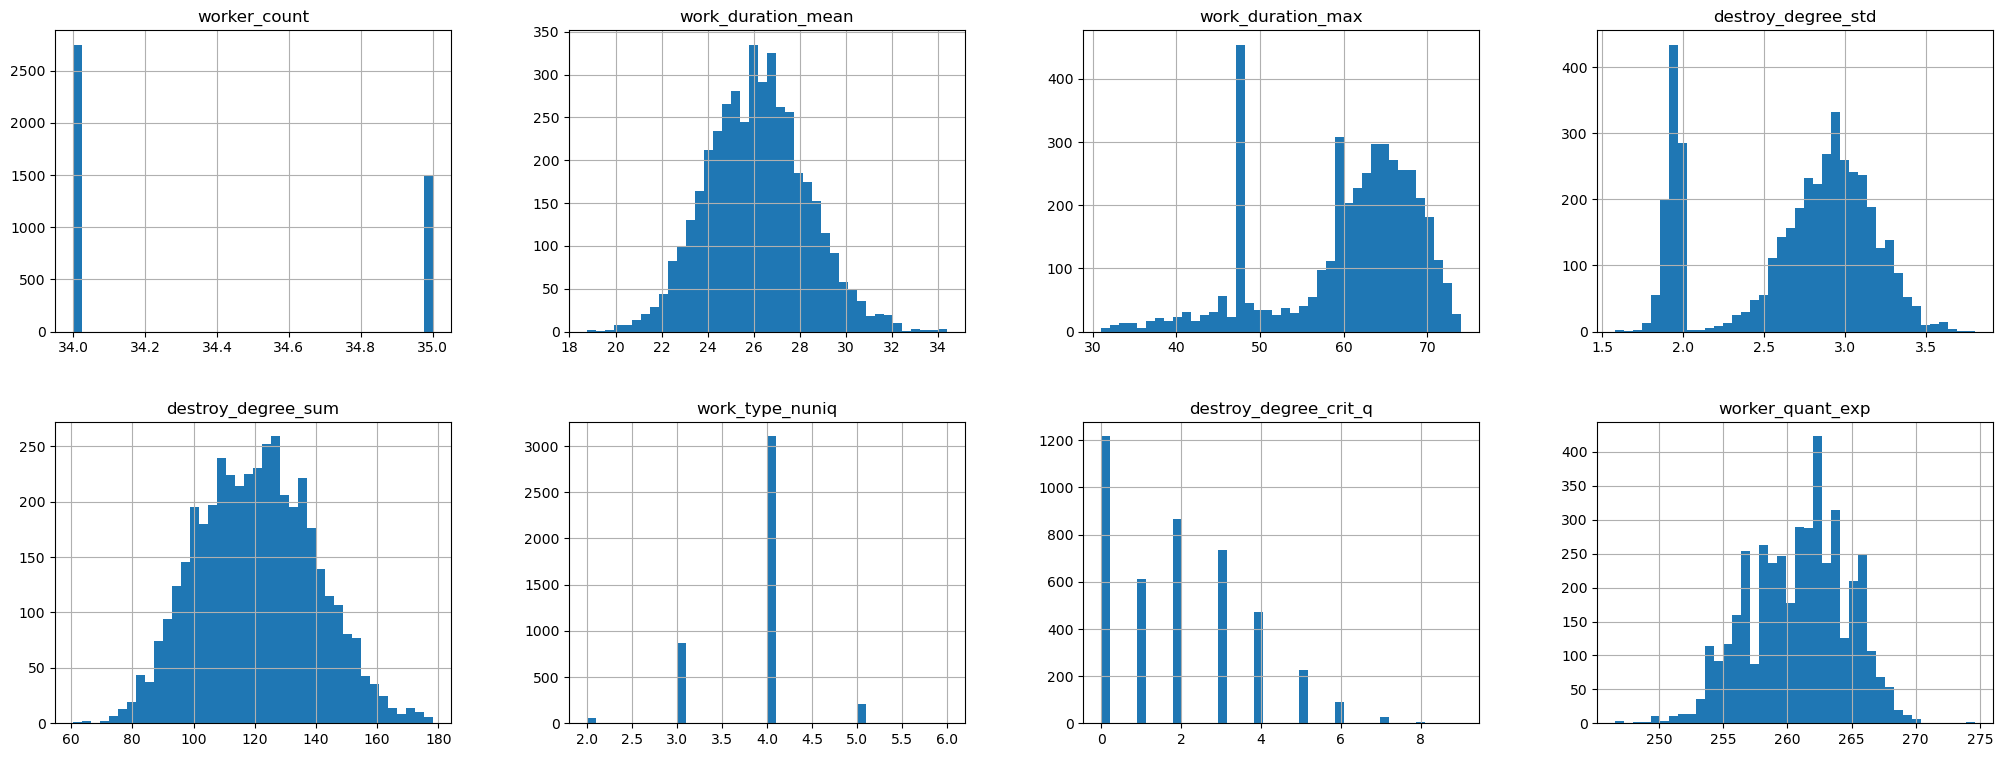

In [15]:
fix_info_gr.hist(figsize=(25, 9), layout=(2, 4), bins=40);

# <center> ⚠️ Проверяйте признаки! ⚠️

<div class="alert alert-info">
    
При генерации фичей легко может пойти что-то не так. <br>
Вы задумывали одно, а получили на деле совсем иное. 
    
* `df.feature.hist()` - вывести гистограмму 
* `df.feature.value_counts()` - вывести численное распределение
    
<p id="check1"></p>   

,car_id,good_feature,gold_feature,killer_feature,bad_feature
3584,s-1689007T,27.500000,64,3.078492,0
1729,V-2090794j,29.176471,64,1.953426,0
1481,R99178335S,23.411765,51,2.521227,0


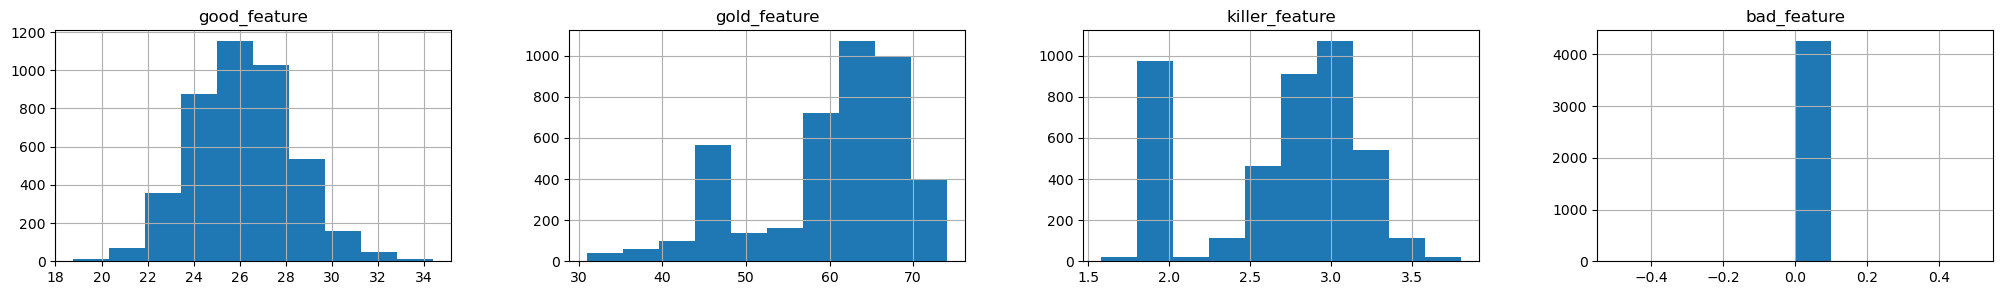

In [16]:
bad_func = lambda x: sum(x <= -100)

tmp = fix_info.groupby("car_id", as_index=False).agg(

    # Все встроенные статистики
    good_feature =("work_duration", "mean"),
    gold_feature =("work_duration", "max"),
    killer_feature =("destroy_degree", "std"),

    # Самописные функции для категорий
    bad_feature =("destroy_degree", bad_func),
)

tmp.hist(figsize=(25, 3), layout=(1, 4))
tmp.sample(3)



<!-- hide  -->

#  Генерация признаков 👉 Визуальный анализ признаков 👉 Генерация признаков

In [20]:
# Добавим к исходной таблице новые признаки
tmp = train.merge(fix_info_gr, on="car_id", how="left")
tmp.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,worker_count,work_duration_mean,work_duration_max,destroy_degree_std,destroy_degree_sum,work_type_nuniq,work_type_mode,work_type_second_mode,destroy_degree_crit_q,worker_quant_exp
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,35,26.657143,56,2.732847,106.7,4,reparking,repair,2,268.2
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,35,24.942857,48,2.707233,102.1,5,reparking,repair,1,257.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,35,26.142857,59,2.978077,130.9,5,repair,reparking,2,261.4


1

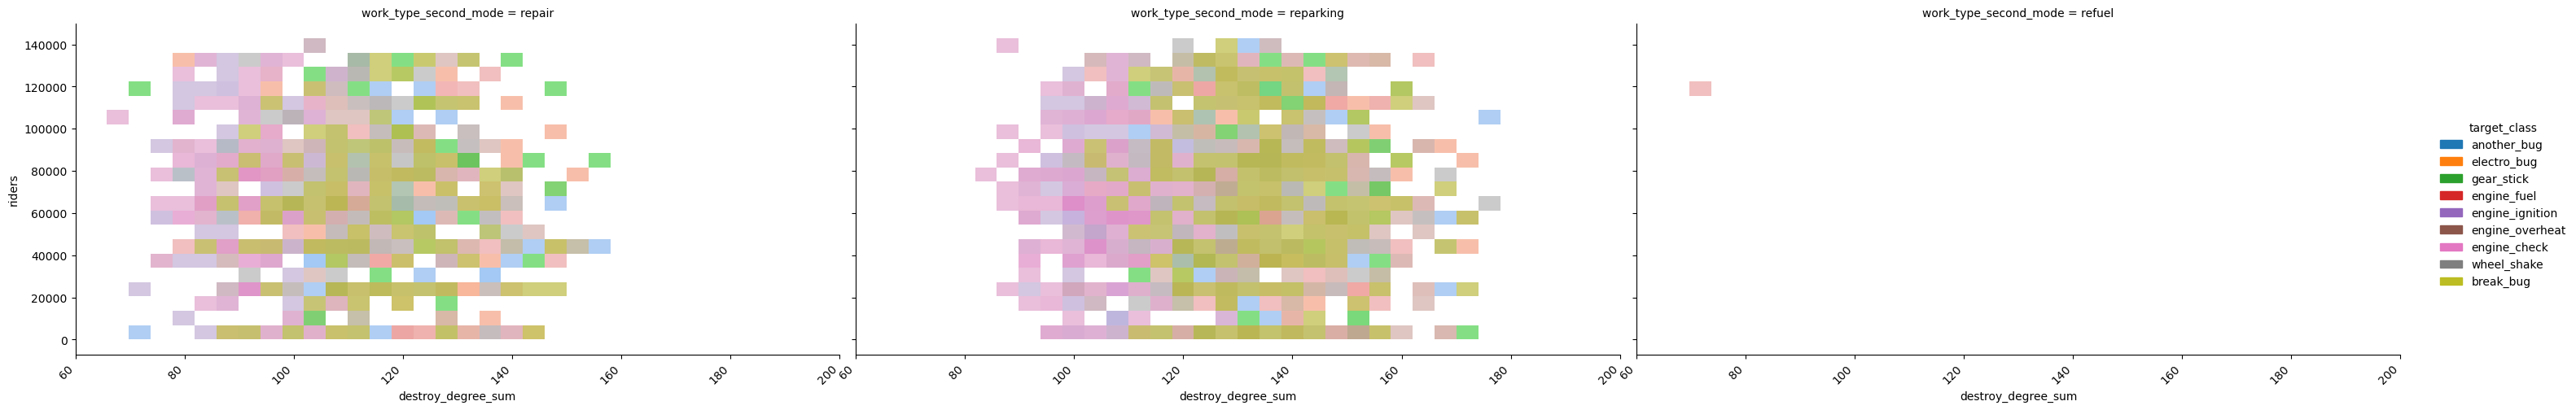

In [21]:
import seaborn as sns

g = sns.displot(
    data=tmp,
    x="destroy_degree_sum",
    y="riders",
    aspect=2,
    kind="hist",
    alpha=0.8,
    hue="target_class",
    col="work_type_second_mode",
).set_xticklabels(rotation=45, horizontalalignment="right")
1

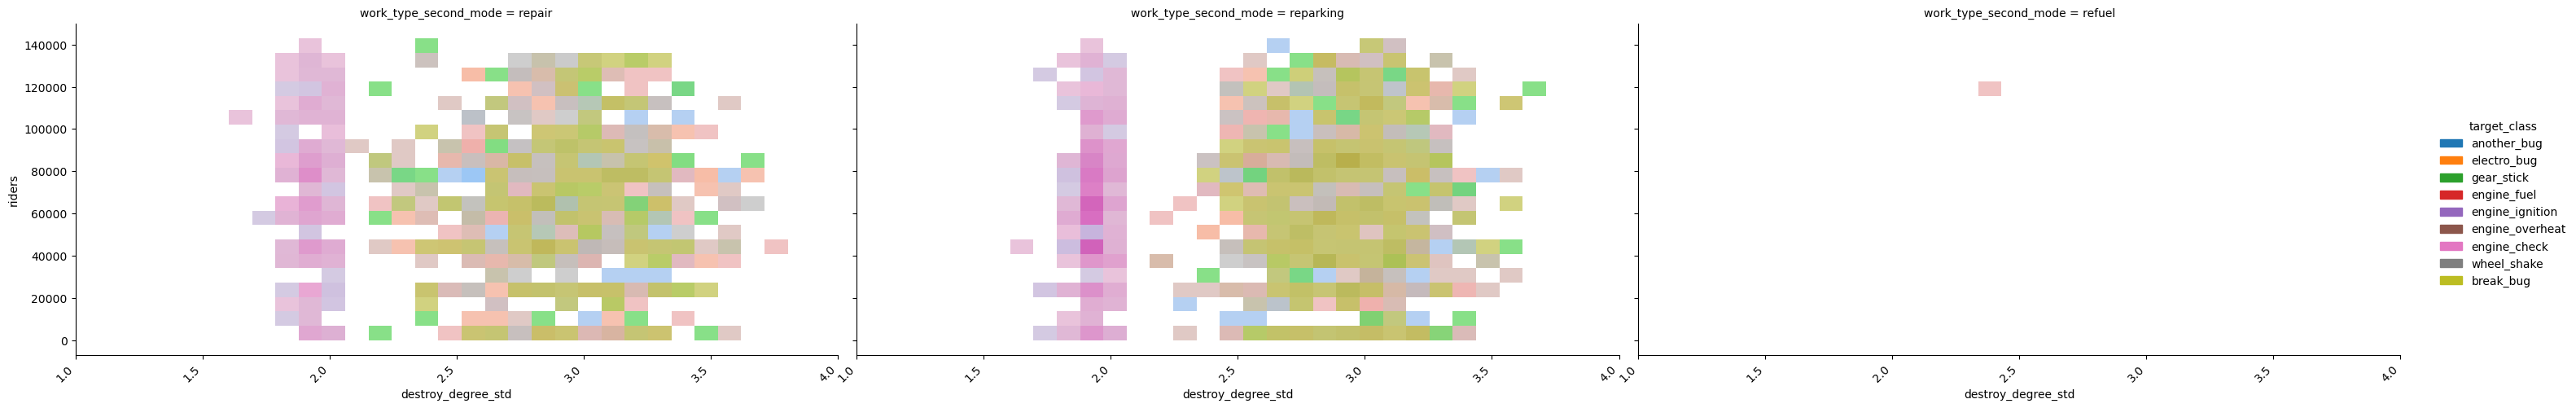

In [22]:
g = sns.displot(
    data=tmp,
    x="destroy_degree_std",
    y="riders",
    aspect=2,
    kind="hist",
    alpha=0.8,
    hue="target_class",
    col="work_type_second_mode",
).set_xticklabels(rotation=45, horizontalalignment="right");

<div class="alert alert-info">
    
Визуально видно, что `destroy_degree_std` полезнее для классификации, чем признак `destroy_degree_sum`

# Связка: `pivot()`/`pivot_table()` + `aggfunc()`

<center><img src='https://raw.githubusercontent.com/dm-fedorov/pandas_basic/master/pic/pivot_table_pandas.png' width=700>

In [23]:
fix_info.head(3)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration,worker_speed,worker_experience
38176,m-8902512v,AB,2019-2-16 19:28,repair,5.0,59,26.219917,241
25968,h-5894617f,AB,2020-8-13 18:19,reparking,1.0,30,26.219917,241
17050,m-8965256V,AB,2020-5-1 10:20,repair,5.0,33,26.219917,241


In [24]:
fix_info_pivot = fix_info.pivot_table(
    index="car_id",  # Строка, для которой хотим сгенерировать признаки
    columns=["work_type"],  # колонка, которую вытяним в столбец
    values=["destroy_degree"],  # столбец, по которой будем считать статистики
    aggfunc=["mean", 'count'],  # признаки для генерации (mean/count/sum)
).fillna(0)

fix_info_pivot.columns = [f"{i[2]}_{i[0]}" for i in fix_info_pivot.columns]
fix_info_pivot.reset_index(inplace=True)

fix_info_pivot.sample(3)

,car_id,oil_change_mean,refuel_mean,refuel_check_mean,refuel_reparking_mean,repair_mean,reparking_mean,oil_change_count,refuel_count,refuel_check_count,refuel_reparking_count,repair_count,reparking_count
1843,W20898223q,0.0,1.0,0.0,0.0,4.776471,1.000,0.0,2.0,0.0,0.0,17.0,15.0
988,M-4627743Y,0.0,1.0,1.0,0.0,6.406250,2.000,0.0,2.0,1.0,0.0,16.0,16.0
3521,r-6268123s,0.0,1.0,1.0,0.0,5.347368,2.125,0.0,3.0,4.0,0.0,19.0,8.0


# Генерируем фичи по водителям

In [26]:
import pandas as pd

train = pd.read_csv("car_train.csv")
rides = pd.read_csv("rides_info.csv")

rides = train.merge(rides, on="car_id", how="left")
rides.head(4)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,5.72,220,3514,42,NaN,6,1.682556e+03,0,0.524750,0.0
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2.52,37392,523483,45,53.0,2,1.711379e+06,0,1.723151,0.0
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,7.17,45,444,54,82.0,0,9.523155e+02,0,0.876440,-0.0
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,6.19,10,105,35,40.0,0,2.372539e+02,0,1.274242,-0.0


# < Что вообще можно сгенерировать через `groupby`? 🧠
  
    
        
    
Для каждой машины есть своя история поездок, у которой, в зависимости от будущей поломки есть свои паттерны    
    
- Статистики (среднее/дисперсия/максимум/количество)
- Сложные признаки с помощью функций